In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import lab4_hmc as hmc

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [3]:
X_train = np.array(df_train.iloc[:, :-1])
y_train = np.array(df_train.iloc[:, -1])
X_test = np.array(df_test.iloc[:, :-1])
y_test = np.array(df_test.iloc[:, -1])

scaler = StandardScaler() # Standardise input variables

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
### EXAMPLES
def e_func(x, f):
    # Simulating some unknown log-probability
    p0 = -x[0]**2/2
    p1 = -x[1]**2/2 + np.log(2+np.cos(f*x[1]))
    lgp = p0 + p1
    return -lgp

def e_grad(x, f):
    g = np.empty(2)
    g[0] = x[0]
    g[1] = x[1] + f*np.sin(f*x[1]) / (2+np.cos(f*x[1]))
    return g

### Define Functions Here

In [5]:
# X is observation data, x is hyperparameter set sigma_w_2 and sigma_n_2

def compute_log_marginal(x, X, t): # p(t|sigma_n_2, sigma_w_2)
    sigma_w_2 = x[0]
    sigma_n_2 = x[1]
    N = X.shape[0]
    cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
    return stats.multivariate_normal.logpdf(t, mean=None, cov=cov, allow_singular=True)

# log uniform prior for both hyperparameters as they are scale parameters
def e_func(x, X, t):
    sigma_w_2 = x[0]
    sigma_n_2 = x[1]
    lgp = compute_log_marginal(x, X, t) + np.log(sigma_w_2) + np.log(sigma_n_2)
    return -lgp # -ve log prob

def e_grad(x, X, t):
    sigma_w_2 = x[0]
    sigma_n_2 = x[1]
    N = X.shape[0]
    cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
    cov_inv = np.linalg.inv(cov)
    deriv_w = X@X.T
    deriv_n = np.eye(N)
    
    grad_0 = t.T@cov_inv@deriv_w@cov_inv@t.T / 2 - np.trace(cov_inv@deriv_w) / 2 + 1/sigma_w_2
    grad_1 = t.T@cov_inv@deriv_n@cov_inv@t.T / 2 - np.trace(cov_inv@deriv_n) / 2 + 1/sigma_n_2
    
    return np.array([-grad_0, -grad_1])

In [6]:
X = X_train
t = y_train

In [7]:
x0 = np.array([0.5, 20]) # random point to start
hmc.gradient_check(x0, e_func, e_grad, X, t)

Calc.         Numeric       Delta         Acc.
    -84.1394      -84.1394   2.655279e-06   8
    -248.012      -248.012  -1.469431e-06   9


In [17]:
#
np.random.seed(seed=1)  # For reproducibility
R = 1000
burn = int(R/10)
L = 100  # OK here (should be larger in regression sampling)
eps = 0.69  # Trial-and-error ... feel free to experiment!

S, *_ = hmc.sample(x0, e_func, e_grad, R, L, eps, burn=burn, checkgrad=True, args=[X, t])


Calc.         Numeric       Delta         Acc.
    -84.1394      -84.1394   2.655279e-06   8
    -248.012      -248.012  -1.469431e-06   9
|----------|  0% accepted [ 615 secs to go ]
|#---------|  7% accepted [ 558 secs to go ]
|##--------| 53% accepted [ 498 secs to go ]
|###-------| 69% accepted [ 433 secs to go ]
|####------| 77% accepted [ 371 secs to go ]
|#####-----| 81% accepted [ 308 secs to go ]
|######----| 84% accepted [ 247 secs to go ]
|#######---| 87% accepted [ 185 secs to go ]
|########--| 88% accepted [ 123 secs to go ]
|#########-| 90% accepted [ 61 secs to go ]
|##########| 91% accepted [ 1 secs to go ]
HMC: R=1000 / L=100 / eps=0.69 / Accept=90.6%


In [18]:
S.shape

(1000, 2)

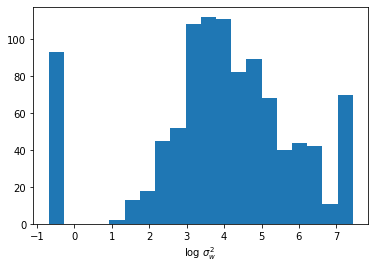

In [19]:
plt.hist(np.log(S[:,0]), bins=20)
plt.xlabel("log $\sigma_w^2$");

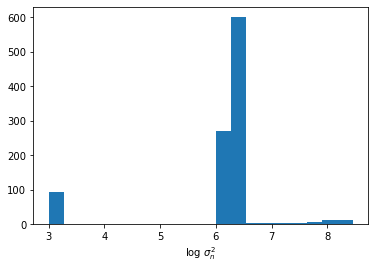

In [20]:
plt.hist(np.log(S[:,1]), bins=20)
plt.xlabel("log $\sigma_n^2$");

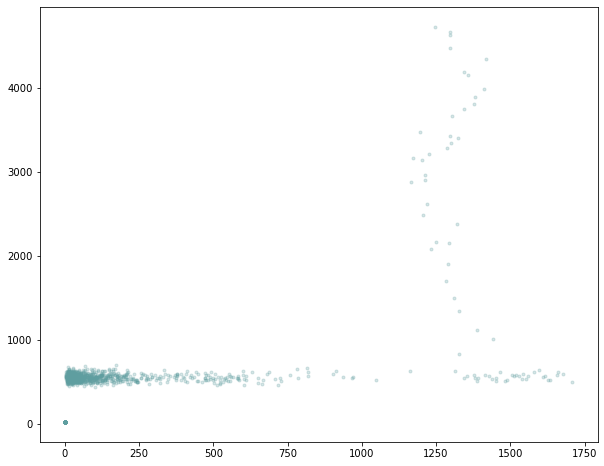

In [21]:
fsz = (10,8)
gsz = 100
lim = 3
#
gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))
#
# plt.figure(figsize=fsz)
# plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
# plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [22]:
sigma_w_2_opt = np.mean(S[:, 0])
sigma_n_2_opt = np.mean(S[:, 1])

In [23]:
print("Optimised:")
print("sigma_w_2 = {} sigma_n_2 = {}".format(sigma_w_2_opt, sigma_n_2_opt))

Optimised:
sigma_w_2 = 205.5609719079909 sigma_n_2 = 592.1910624031282


### Calculate gradient w and RMSE

In [26]:
def get_w(X, y, sigma_n_2, sigma_w_2):
    return np.linalg.inv(X.T@X + sigma_n_2*(1/sigma_w_2)*np.eye(X.shape[1]))@X.T@y

In [27]:
w = get_w(X_train, y_train, sigma_n_2_opt, sigma_w_2_opt)
w

array([-3.92399153, -1.87839126,  1.37597292, -2.49486455,  7.70887695,
       -0.13136096,  2.76685421,  0.18654982])

In [28]:
y_intercept = y_train.mean()

In [30]:
y_test_pred = X_test@w + y_intercept

In [31]:
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print("test RMSE =", rmse_test)

test RMSE = 2.859220404668006


In [32]:
def error_histogram(y_pred, y_targ):
    error_list = y_pred.reshape(-1, 1) - y_targ.reshape(-1, 1)
    plt.hist(error_list, bins=20)
    plt.xlabel("Error")
    plt.ylabel("Number of samples in the bin")
    plt.show()

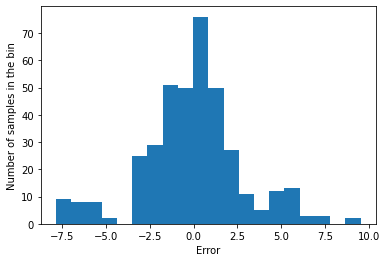

In [33]:
error_histogram(y_test_pred, y_test)